In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import sourses.paths as path
import sourses.class_id as class_id
import sourses.prepare_data as prepare_data

## Global parameters

In [2]:
train_path = path.train_path
test_path = path.test_class_id_path

batch_size = prepare_data.batch_size
img_height = prepare_data.img_height
img_width = prepare_data.img_width

epochs = 35

## Loading data from local
- The train data is split into training data and valitation data

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False
)

Found 12630 files belonging to 43 classes.


In [6]:
class_names = train_ds.class_names
for i,j in enumerate(class_names):
    class_names[i] = class_id.class_id[j]
    
num_classes = len(class_names)

## Data standardization

In [7]:
IMG_SIZE = 180

normalization_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Data augmentation

In [8]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
test_ds = test_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

## Building the model

In [9]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

## Training the model

In [10]:
training = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/35
981/981 [==============================] - 458s 467ms/step - loss: 3.4238 - accuracy: 0.0818 - val_loss: 2.9596 - val_accuracy: 0.1959
Epoch 2/35
981/981 [==============================] - 453s 462ms/step - loss: 2.1446 - accuracy: 0.3807 - val_loss: 1.4861 - val_accuracy: 0.5432
Epoch 3/35
981/981 [==============================] - 428s 436ms/step - loss: 1.3281 - accuracy: 0.5889 - val_loss: 1.1495 - val_accuracy: 0.6512
Epoch 4/35
981/981 [==============================] - 460s 469ms/step - loss: 1.0659 - accuracy: 0.6692 - val_loss: 1.0038 - val_accuracy: 0.6930
Epoch 5/35
981/981 [==============================] - 458s 467ms/step - loss: 0.8952 - accuracy: 0.7248 - val_loss: 0.7958 - val_accuracy: 0.7618
Epoch 6/35
981/981 [==============================] - 463s 472ms/step - loss: 0.7788 - accuracy: 0.7549 - val_loss: 0.6806 - val_accuracy: 0.7958
Epoch 7/35
981/981 [==============================] - 467s 476ms/step - loss: 0.7055 - accuracy: 0.7779 - val_loss: 0.6670 -

## Evaluating its performance

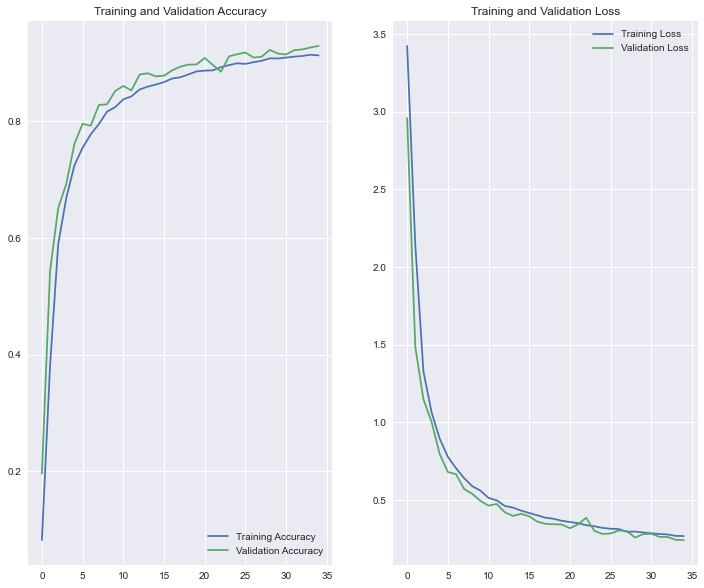

In [11]:
plt.style.use('seaborn')

model_name = 'model_3'

acc = training.history['accuracy']
val_acc = training.history['val_accuracy']

loss = training.history['loss']
val_loss = training.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig(f'../outputs/charts/{model_name}.png')
plt.show()

## Model evaluation
Things to do:
- Evaluate the model with the evaluate method of tensorflow, whatch example on tensorflow.org
- Try to compare real labels (y_test) with prediction labels (y_pred)

In [21]:
img = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    image_size=(img_height, img_width)
)

Found 12630 files belonging to 43 classes.


In [22]:
predictions = training.predict(img, verbose=1)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

AttributeError: 'str' object has no attribute 'predict'

## Saving the model

In [12]:
# Save the entire model as a SavedModel.
model.save(f'../outputs/models/{model_name}')

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(f'../outputs/models/{model_name}.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../outputs/models/model_3/assets
